In [30]:
import warnings

import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting import TimeSeriesDataSet
from ray import tune
from ray.train import CheckpointConfig, RunConfig, ScalingConfig
from ray.train.lightning import RayTrainReportCallback
from ray.train.torch import TorchTrainer
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sktime.split import temporal_train_test_split

warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
%matplotlib inline
%config InlineBackend.figure_format='retina'

## 读取数据


In [9]:
df = pd.read_csv(
    "../data/dnaq_15Min_interval.csv",
    parse_dates=["collection_time"],
    index_col="collection_time",
)
N_LAGS = 12
HORIZON = 1
df = df[["Ia", "Ib", "Ic", "Ua", "Ub", "Uc"]]
n_vars = df.shape[1] - 1

## 定义多元时间序列数据集


In [10]:
class MultivariateSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
        target_name: str = "",
    ):
        super().__init__()
        self.data = data
        self.feature_names = [col for col in data.columns if col != target_name]
        self.batch_size = batch_size
        self.test_size = test_size
        self.n_lags = n_lags
        self.horizon = horizon
        self.target_name = target_name
        self.target_scaler = MinMaxScaler()
        self.training: TimeSeriesDataSet
        self.validation: TimeSeriesDataSet
        self.test: TimeSeriesDataSet
        self.predict: TimeSeriesDataSet
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.target_name]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = 0

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None):
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        train_df = train_df.drop(self.target_name, axis=1)
        val_df = val_df.drop(self.target_name, axis=1)
        test_df = test_df.drop(self.target_name, axis=1)

        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=self.feature_names,
            scalers={name: MinMaxScaler() for name in self.feature_names},
        )
        self.validation = TimeSeriesDataSet.from_dataset(
            self.training, val_df, stop_randomization=True
        )
        self.test = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )
        self.predict = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict.to_dataloader(batch_size=1, shuffle=False)

## 定义 LSTM 模型


In [22]:
from torchmetrics import (
    MeanAbsoluteError,
    MeanSquaredError,
)


class LSTMModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 1,
        hidden_dim: int = 128,
        num_layers: int = 2,
        output_dim: int = 1,
        lr: float = 0.001,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=output_dim)

        self.train_mae = MeanAbsoluteError()
        self.train_mse = MeanSquaredError()
        self.train_rmse = MeanSquaredError(squared=False)
        self.val_mae = MeanAbsoluteError()
        self.val_mse = MeanSquaredError()
        self.val_rmse = MeanSquaredError(squared=False)
        self.test_mae = MeanAbsoluteError()
        self.test_mse = MeanSquaredError()
        self.test_rmse = MeanSquaredError(squared=False)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        self.log("train_mae", self.train_mae(y_pred, y[0]))
        self.log("train_mse", self.train_mse(y_pred, y[0]))
        self.log("train_rmse", self.train_rmse(y_pred, y[0]))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)
        self.log("test_mae", self.test_mae(y_pred, y[0]))
        self.log("test_mse", self.test_mse(y_pred, y[0]))
        self.log("test_rmse", self.test_rmse(y_pred, y[0]))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("validation_loss", loss)
        self.log("val_mae", self.val_mae(y_pred, y[0]))
        self.log("val_mse", self.val_mse(y_pred, y[0]))
        self.log("val_rmse", self.val_rmse(y_pred, y[0]))
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        y_pred = y_pred.detach().numpy()
        y_pred = self.trainer.datamodule.target_scaler.inverse_transform(y_pred)
        return y_pred

    def configure_optimizers(self):
        optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimiser

In [12]:
model = LSTMModel(input_dim=n_vars, hidden_dim=32, num_layers=2, output_dim=1, lr=0.001)

## 预测 Ia


In [13]:
datamodule = MultivariateSeriesDataModule(
    data=df,
    n_lags=N_LAGS,
    horizon=HORIZON,
    test_size=0.2,
    batch_size=16,
    target_name="Ia",
)

In [14]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

In [15]:
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

pl.seed_everything(42)
logger = TensorBoardLogger("lightning_logs", name="Ia-prediction-12-steps")

early_stop_callback = EarlyStopping(
    monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

rich_progress_bar = RichProgressBar()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stop_callback, rich_progress_bar],
    max_epochs=500,
    accelerator="cpu",
)
trainer.fit(model, datamodule)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/Ia-prediction-12-steps


┏━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ lstm       │ LSTM              │ 13.4 K │
│ 1  │ dropout    │ Dropout           │      0 │
│ 2  │ fc1        │ Linear            │    528 │
│ 3  │ fc2        │ Linear            │     17 │
│ 4  │ train_mae  │ MeanAbsoluteError │      0 │
│ 5  │ train_mse  │ MeanSquaredError  │      0 │
│ 6  │ train_rmse │ MeanSquaredError  │      0 │
│ 7  │ val_mae    │ MeanAbsoluteError │      0 │
│ 8  │ val_mse    │ MeanSquaredError  │      0 │
│ 9  │ val_rmse   │ MeanSquaredError  │      0 │
│ 10 │ test_mae   │ MeanAbsoluteError │      0 │
│ 11 │ test_mse   │ MeanSquaredError  │      0 │
│ 12 │ test_rmse  │ MeanSquaredError  │      0 │
└────┴────────────┴───────────────────┴────────┘

Trainable params: 14.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.0 K                                                                                               
Total estimated model params size (MB): 0

Output()

In [20]:
trainer.test(model, datamodule.test_dataloader())

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0060181948356330395   │
│         test_mae          │            nan            │
│         test_mse          │            nan            │
│         test_rmse         │            nan            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0060181948356330395,
  'test_mae': nan,
  'test_mse': nan,
  'test_rmse': nan}]

In [21]:
trainer.validate(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_mae          │            nan            │
│          val_mse          │            nan            │
│         val_rmse          │            nan            │
│      validation_loss      │   0.009762885048985481    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.009762885048985481,
  'val_mae': nan,
  'val_mse': nan,
  'val_rmse': nan}]

Output()

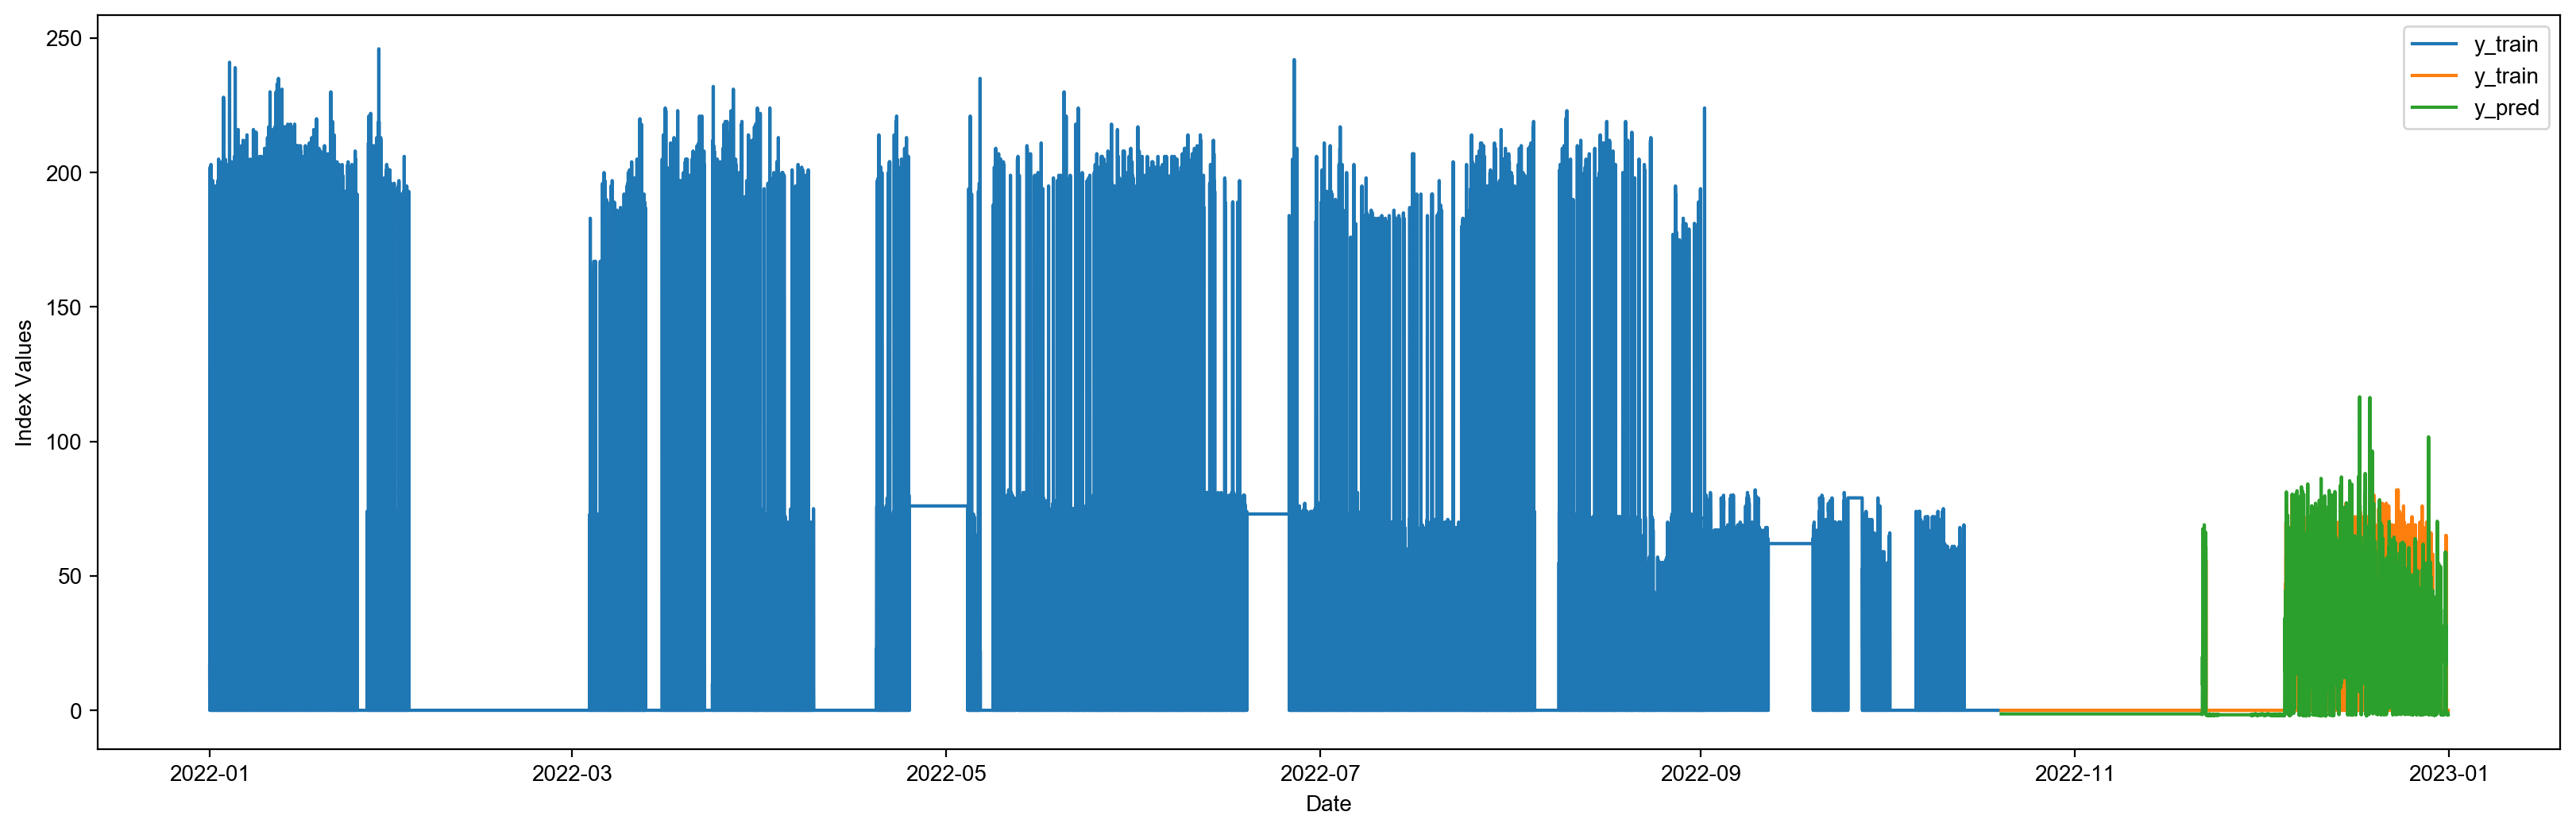

In [23]:
prediction = trainer.predict(model=model, datamodule=datamodule)
prediction = np.concatenate(prediction)
prediction = prediction.flatten()
y_train, y_test = temporal_train_test_split(df["Ia"], test_size=0.2)
y_test = y_test.iloc[: len(prediction)]
y_pred = pd.Series(prediction, index=y_test.index)

plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train, label="y_train")
plt.plot(y_test.index, y_test, label="y_train")
plt.plot(y_pred.index, y_pred, label="y_pred")
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.legend()
plt.show()

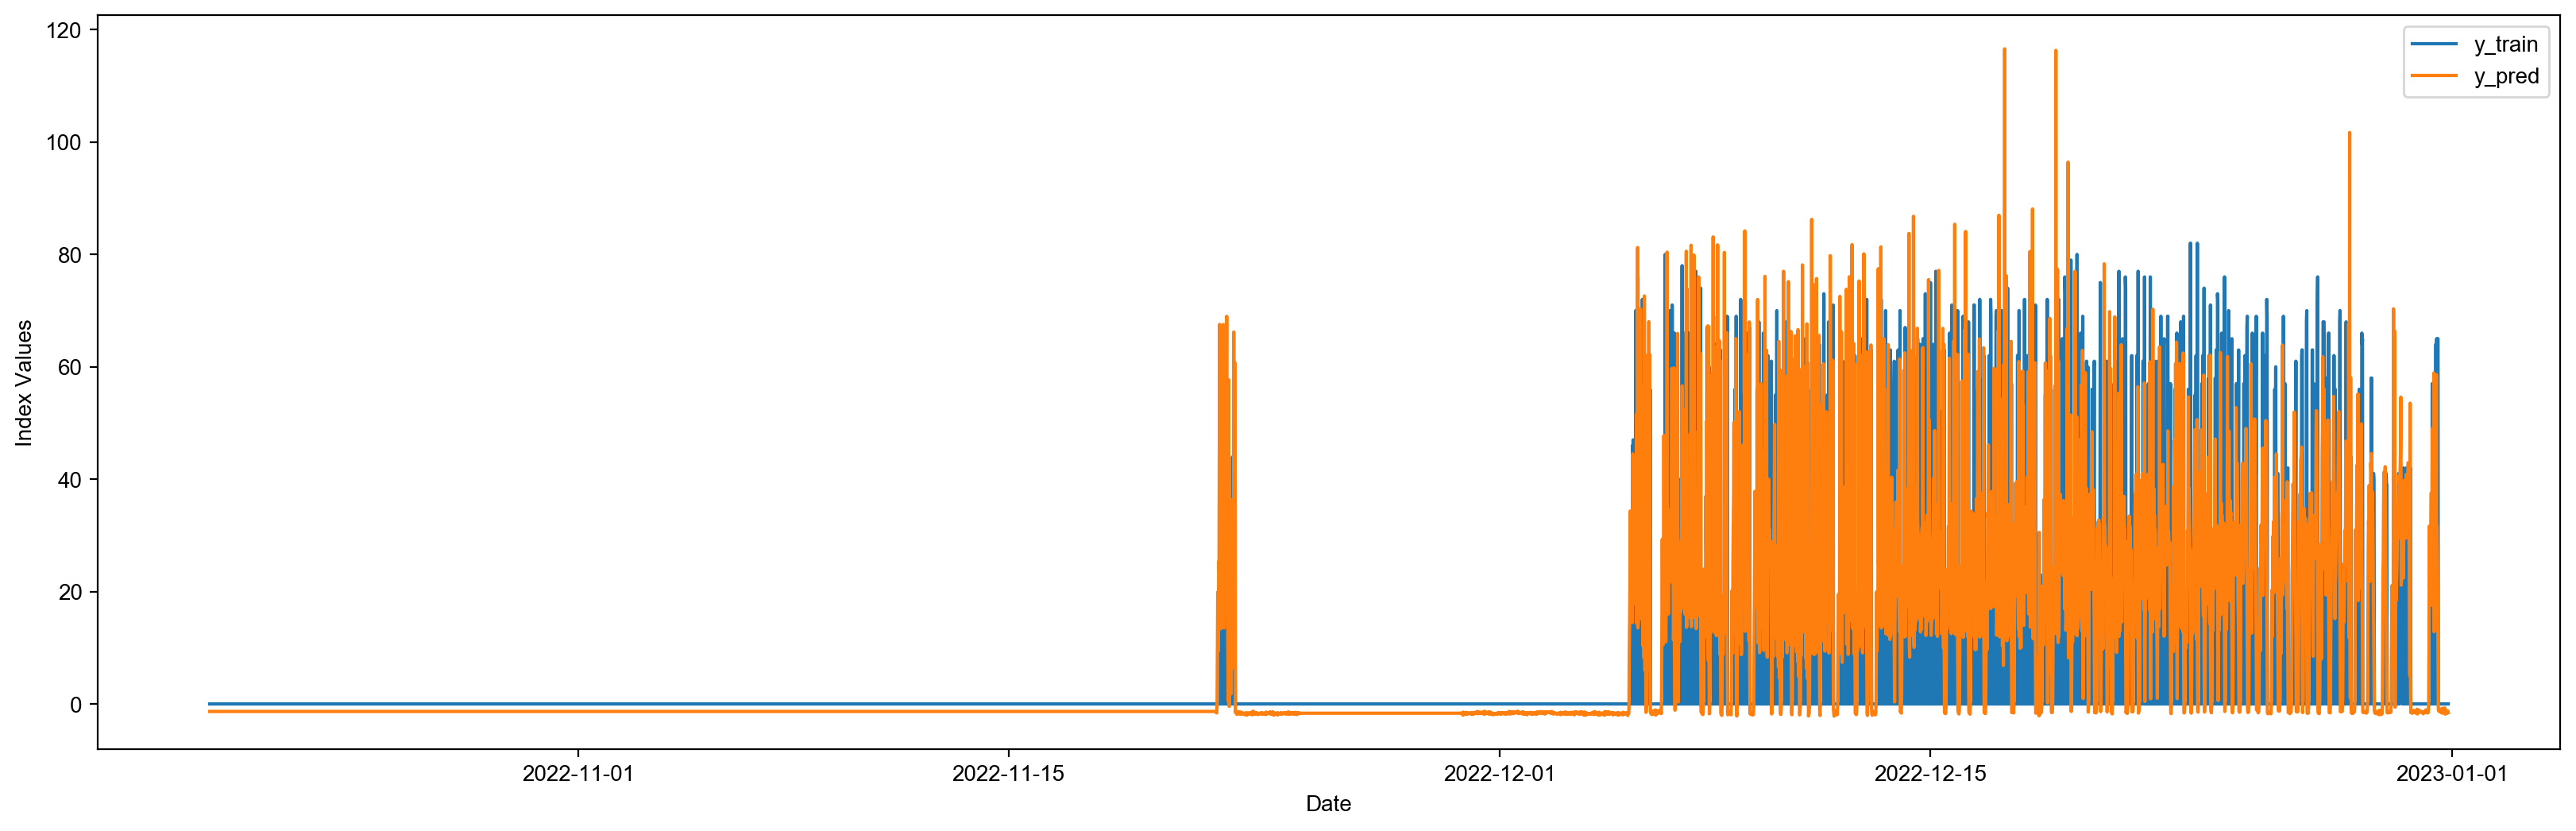

In [24]:
y_train, y_test = temporal_train_test_split(df["Ia"], test_size=0.2)
y_test = y_test.iloc[: len(prediction)]
y_pred = pd.Series(prediction, index=y_test.index)

plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label="y_train")
plt.plot(y_pred.index, y_pred, label="y_pred")
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.legend()
plt.show()

### 参数调优


In [31]:
# 定义参数搜索空间
search_space = {
    "hidden_dim": tune.choice([32, 64, 128, 256]),
    "num_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-1),
}

In [32]:
def train_tune(config_hyper):
    hidden_dim = config_hyper["hidden_dim"]
    num_layers = config_hyper["num_layers"]

    model = LSTMModel(
        input_dim=1,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        lr=config_hyper["lr"],
    )

    data_module = MultivariateSeriesDataModule(
        data=df,
        n_lags=N_LAGS,
        horizon=HORIZON,
        test_size=0.2,
        batch_size=16,
        target_name="Ia",
    )
    trainer = pl.Trainer(callbacks=[RayTrainReportCallback()])
    trainer.fit(model, data_module)

In [ ]:
# 定义调度器
scaling_config = ScalingConfig(use_gpu=False, resources_per_worker={"CPU": 1, "GPU": 0})
run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=1,
        checkpoint_score_attribute="validation_loss",
        checkpoint_score_order="min",
    ),
)
ray_trainer = TorchTrainer(
    train_tune,
    scaling_config=scaling_config,
    run_config=run_config,
)
scheduler = ASHAScheduler(grace_period=1, reduction_factor=2)
tuner = tune.Tuner(
    ray_trainer,
    param_space={"train_loop_config": search_space},
    tune_config=tune.TuneConfig(
        metric="validation_loss",
        mode="min",
        num_samples=2,
        scheduler=scheduler,
    ),
)
results = tuner.fit()

In [ ]:
best_model_conf = results.get_best_result(metric="validation_loss", mode="min")
best_model_conf

### 导出模型


In [26]:
model.eval()
torch.onnx.export(
    model,
    torch.randn(1, N_LAGS, n_vars),
    "./models/lstm_12_step_Ia.onnx",
    export_params=True,
)